<a href="https://colab.research.google.com/github/tomcaputo/aws_product_embeddings/blob/main/PinnerFormer_Sequence_Modeling_for_User_Representation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# PinnerFormer: Sequence Modeling for User Representation.ipynb

- Model is updated once a day
- Action is a concatenation of the action embedding (PinSage), and meta feature embedding
- Meta features include: action type, surface, timestamp, and action duration
- Feature Encoding: timestamp is encoded as raw timestamp, time since last action, and time gap between actions. o Time2vec [11], but with 𝑃 fixed periods,
rather than learned periods, and a logarithmic transformation of
time, rather than a linear one. This produces 2𝑃 + 1 features (2𝑃
from periodic transofmrations of the timestamp).1
- Users are represented by the sequence of actions
- Sequence of actions A, is the only input into the model
- some actions can be good, others can be neutral or negative. This model seeks to only predict positive actions (over a 14 day period)
- the assumption being two weeks are sufficiently are representative of a
user’s longer-term interests.


Model Architecture:
- Learnable positional Encoding
Standard transformer
- to represent Pins:
  - pinsage as input
  - MLP
  - L2 normalize the embeddings


Metric Learning
- No explicit negative feedback
- Negative Selection:
  - Considerations: inbatch negatives can bias towards popular. random selection from the corpus may be too easy for the model. The Authors use a hybrid approach
  - In Batch negatives: all positive examples from other users. Masked pins that are positive for the user

  - Random negatives: Random sample from

This model seeks to represent users in a way that is compatible with the Pin Representation from PinSage



Feature Encoding:
- ing to use 𝑃abs periods of real-life importance and fractions thereof:
0.25h, 0.5h, 0.75h, 1h, 2h, 4h, 8h, 16h, 1d, 7d, 28d, and 365d.





The following is a notebook which implements the simplest version of [SASRec paper](https://cseweb.ucsd.edu/~jmcauley/pdfs/icdm18.pdf), Kang, W.-C., & McAuley, J. (2018). SASRec is the seminal Transformer based approach for Recommendation.

There are many additional ways to modify this technique. This is implemented as specified in the paper and benchmarked on the [2023 Amazon Product Review dataset](https://amazon-reviews-2023.github.io/).

### Introduction to SASRec

Sequential recommendation systems model user behavior as an ordered sequence of interactions. Traditional methods, like matrix factorization, often fail to capture temporal dependencies within these sequences. SASRec (Self-Attentive Sequential Recommendation) addresses this by leveraging the transformer architecture, originally designed for NLP, to model these dependencies effectively.

Self-Attention Mechanism: SASRec uses self-attention to dynamically focus on relevant past interactions within a sequence, allowing it to capture complex dependencies and contextual information without being limited by fixed-size history windows.


Here are the primary difference from Attention is All You Need

*   Learned positional encoding
*   Encoder only
*   shorter sequences, larger "vocabulary" of tokens


### References
Vaswani, A., et al. (2017). "Attention Is All You Need." Advances in Neural Information Processing Systems.
Kang, W.-C., & McAuley, J. (2018). "Self-Attentive Sequential Recommendation." Proceedings of the IEEE International Conference on Data Mining.


## Notebook Setup

In [ ]:
!pip install datasets
!pip install pytorch-lightning
!pip install faiss-gpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.3/474.3 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 46.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.7 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 13.1 M

In [ ]:
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt

import json
import copy

from datasets import load_dataset

import faiss

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import pytorch_lightning as pl

from sklearn.preprocessing import LabelEncoder

In [ ]:
sys.path.append("/content/drive/MyDrive/Colab Notebooks/RAG/")
from google.colab import drive
drive.mount('/content/drive')
data_dir = '/content/drive/MyDrive/Colab Notebooks/RAG/'

Mounted at /content/drive


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [ ]:
num_gpus = torch.cuda.device_count()
print(f"Number of GPUs available: {num_gpus}")

Number of GPUs available: 1


## Amazon 2023 data set


The Amazon Reviews 2023 dataset, collected to ensure up-to-date training corpora for LLMs, is significantly more extensive than its predecessors. It contains millions of reviews with accompanying text, ratings, and timestamps, making it ideal for benchmarking recommender systems.


*   It features 3.18 times more items and 2.4 times more reviews and metadata

*   The metadata is richer and cleaner, parsed from HTML into JSON, with more descriptive fields and multi-modal content such as videos and images

  [Full Description](https://amazon-reviews-2023.github.io/)

There are two files that are used:



1.   `amazon_2023_full.parquet`: contains reviews
2.   `amazon_2023_metadata.parquet`: contains metadata on products



## Import Data

In [ ]:
# Load interaction data
download_interaction_data = False
if download_interaction_data:
  interaction_dataset = load_dataset("McAuley-Lab/Amazon-Reviews-2023", "raw_review_Books", trust_remote_code=True)
  print(interaction_dataset["full"][0])
  interaction_dataset["full"].to_parquet(data_dir + 'amazon_2023_full.parquet')

create_downsmaple = False
if create_downsmaple:
  interaction_df = pd.read_parquet(data_dir + 'amazon_2023_full.parquet')


  # identify downsample IDs
  user_purchase_qty = interaction_df.user_id.value_counts()
  user_ids = user_purchase_qty[user_purchase_qty>10].index
  downsample_frac = .1
  rand_ids = np.random.uniform(0, 1, len(user_ids))
  user_ids = pd.Series(user_ids[rand_ids < downsample_frac])

  # downsample
  interaction_df[interaction_df['user_id'].isin(user_ids)].to_parquet(data_dir + 'amazon_2023_downsampled.parquet')

interaction_df = pd.read_parquet(data_dir + 'amazon_2023_downsampled.parquet')


In [ ]:
interaction_df.user_id.nunique()

36099

In [ ]:
interaction_df.head()

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase
148,3.0,Difficult to find particular information,I found it difficult to find the information I...,[],1119683890,1119683890,AF5MJENGAL5G6BUFIVMH5LRSZ6EA,1607924424355,2,True
149,5.0,Great magazine.,I have been looking for this particular copy o...,[],B07QFNN95T,B07QFNN95T,AF5MJENGAL5G6BUFIVMH5LRSZ6EA,1607190980128,0,True
150,5.0,Great weaving patterns,Arrived in great time and packaged well. Great...,[],B00EO3HW9Q,B00EO3HW9Q,AF5MJENGAL5G6BUFIVMH5LRSZ6EA,1604090987266,1,True
151,5.0,Arrived in good time and packaged well.,Arrived in great time in good condition.,[],1570768986,1570768986,AF5MJENGAL5G6BUFIVMH5LRSZ6EA,1604090877968,0,True
152,2.0,Lack of clear intructions.,I purchased this book when it first came out. ...,[],0811716171,0811716171,AF5MJENGAL5G6BUFIVMH5LRSZ6EA,1575163786332,6,True


In [ ]:
download_metadata = False
if download_metadata:
  metadata_dataset = load_dataset("McAuley-Lab/Amazon-Reviews-2023", "raw_meta_Books", trust_remote_code=True)
  print(metadata_dataset["full"][0])
  metadata_dataset["full"].to_parquet(data_dir + 'amazon_2023_metadata.parquet')

create_downsmaple = True
if create_downsmaple:
  metadata_df = pd.read_parquet(data_dir + 'amazon_2023_metadata.parquet')

  # identify downsample IDs
  item_ids = pd.Series(interaction_df['parent_asin']).unique()

  # downsample
  metadata_df[metadata_df['parent_asin'].isin(item_ids)].to_parquet(data_dir + 'amazon_2023_metadata_downsampled.parquet')

metadata_df = pd.read_parquet(data_dir + 'amazon_2023_metadata_downsampled.parquet')

In [ ]:
metadata_df['price'] = metadata_df['price'].str.replace('[^0-9\.]', '', regex=True)\
                                .replace('', np.nan).astype(float)\
                                .fillna(0)

In [ ]:
metadata_df['first_category'] = metadata_df.categories.apply(lambda x: str(x[1]) if len(x)>1 else x)
metadata_df['first_category'] = metadata_df['first_category'].apply(lambda x: str(x[0]) if type(x)=='numpy.ndarray' else str(x))

## Feature Engineering

The Pinterest model

- **Content**:
  - *Pinterest*: The 512 vector embedding coming from the PinSAGE model.
  - Since the scale allows it I'll be learning the product embedding as part of the model
  
- Action:
 - *Pinterest*: Pin, Save, etc.. as well as metadata for this actions. Authors create an embedding layer to encode these features
 - I will only have one action "buy" and the review score, product category


- Timestamp:
  - *Pinterest*: Encodes the raw timestamp using sine and cosine transformations with various periods.
  - Time since last action is log transformed
  - See section A.1 in the paper


In [ ]:
def create_dataset(interaction_ds, metadata_ds):

  """
  Creates a combined dataset by merging interaction data with metadata and adding additional features.

  Args:
    interaction_ds (pd.DataFrame): DataFrame containing review history
    metadata_ds (pd.DataFrame): DataFrame containing product metadata

  Returns:
    pd.DataFrame: A merged DataFrame with added features: 'price', 'first_category', 'timestamp_ts', and 'time_since_last_purch'.

  Notes:
    - The function assumes that both DataFrames have an 'asin' column for merging.
    - The 'timestamp' column in the interaction_ds is assumed to be in milliseconds.
  """

  # add metadata
  ds = pd.merge(interaction_df, metadata_df[['parent_asin', 'price', 'first_category']],
                    how='left', left_on='asin', right_on='parent_asin')


  # convert timestamp
  ds['timestamp_ts'] = pd.to_datetime(ds['timestamp'], unit='ms')

  # duration
  ds['time_since_last_purch'] = ds.groupby('user_id')['timestamp'].diff().fillna(0)
  ds['first_purchase'] = 1
  ds.loc[ds.first_purchase==0, 'time_since_last_purch'] = 0

  # col types:
  metadata = ['rating', 'price', 'first_category']
  id_cols = ['user_id']
  timestamp_cols = ['timestamp', 'time_since_last_purch', 'first_purchase']
  time_stamp_col = 'timestamp'

  # Label Encoding
  user_encoder = LabelEncoder()
  product_encoder = LabelEncoder()
  category_encoder = LabelEncoder()

  ds['user_id'] = user_encoder.fit_transform(ds['user_id'])
  ds['asin'] = product_encoder.fit_transform(ds['asin'])
  ds['first_category'] = product_encoder.fit_transform(ds['first_category'])

  cols = ['asin'] + metadata + timestamp_cols + id_cols

  # split
  ds['is_valid'] = ds.timestamp_ts >= '2023-05-01'
  ds = ds[ds.timestamp_ts>'2010-01-01']

  # sequentialize
  ds = ds[cols].sort_values(time_stamp_col).groupby(id_cols).agg(list).reset_index()

  # filter out users with only 1 purchase
  ds = ds[ds['asin'].apply(lambda x: len(x) > 1)]

  return ds

In [ ]:
ds = create_dataset(interaction_df, metadata_df)

<Axes: >

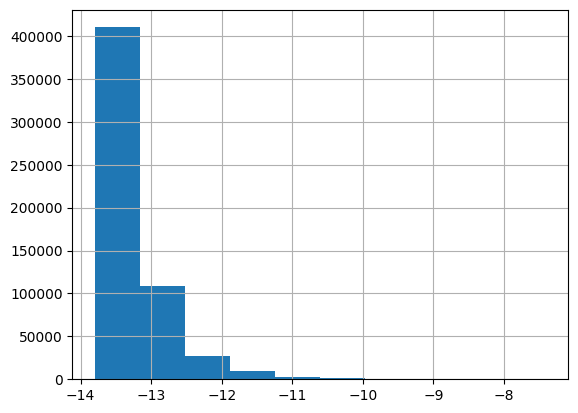

In [ ]:
item_weights = np.log(interaction_df['asin'].value_counts(normalize=True))
item_weights.hist()

In [ ]:
def weighting_lookup(interaction_df, batch_size):
  """
  creates matrix for loss function adjustment

  w = P(pin in batch)

  """

  interaction_df

In [ ]:
ds.head()

,user_id,asin,rating,price,first_category,timestamp,time_since_last_purch,first_purchase
0,0,"[470558, 487579, 475157, 482469, 502008, 39312...","[4.0, 4.0, 4.0, 4.0, 4.0, 5.0, 3.0, 3.0, 4.0, ...","[9.99, 9.99, 10.99, 15.99, 16.49, 35.16, 8.99,...","[107, 107, 107, 107, 118, 46, 98, 107, 154, 86...","[1381407521000, 1383619827000, 1402425068000, ...","[-2212306000.0, -18805241000.0, -4728062000.0,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,1,"[93569, 250425, 86179, 81344, 490909, 462540, ...","[5.0, 5.0, 5.0, 2.0, 1.0, 1.0, 5.0, 4.0, 4.0, ...","[6.8, 10.99, 1.5, 12.51, 2.99, 2.99, 21.95, 16...","[40, 107, 107, 107, 107, 98, 18, 102, 54, 116,...","[1360761027000, 1364239398000, 1364240374000, ...","[-3478371000.0, -976000.0, -9051515000.0, -731...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,2,"[278649, 477802, 295154, 478284, 467257, 46696...","[3.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 3.0, 5.0, ...","[10.95, 79.95, 0.0, 0.0, 9.99, 13.22, 11.99, 2...","[9, 124, 100, 98, 107, 102, 98, 98, 107, 107, ...","[1271910120000, 1329160083000, 1336846829000, ...","[-57249963000.0, -7686746000.0, -26199666000.0...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,3,"[352858, 428995, 347826, 6269, 35595, 216234, ...","[2.0, 5.0, 5.0, 5.0, 5.0, 4.0, 4.0, 4.0, 2.0, ...","[22.89, 10.6, 126.01, 17.45, 34.0, 7.99, 167.5...","[139, 139, 82, 118, 118, 18, 82, 18, 18, 118, ...","[1313019953000, 1314006545000, 1380197402000, ...","[-986592000.0, -66190857000.0, -333352000.0, -...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,4,"[119637, 481339, 284394, 140771, 490847, 46723...","[5.0, 5.0, 4.0, 4.0, 3.0, 5.0, 5.0, 3.0, 2.0]","[8.01, 12.99, 12.48, 9.99, 0.0, 12.99, 0.0, 0....","[98, 98, 147, 147, 98, 107, 107, 98, 98]","[1348199597000, 1406245317000, 1406247851000, ...","[-58045720000.0, -2534000.0, -299000.0, -79882...","[1, 1, 1, 1, 1, 1, 1, 1, 1]"


In [ ]:
class AmazonDataset(Dataset):
    def __init__(self, df, product_col, user_col,
                 metadata_dense_cols, metadata_sparse_cols, timestamp_col,
                 max_len=10):
        super().__init__()
        self.df = df
        self.max_len = max_len
        self.metadata_dense_cols = metadata_dense_cols
        self.metadata_sparse_cols = metadata_sparse_cols
        self.product_col = product_col
        self.timestamp_col = timestamp_col
        self.user_col = user_col

    def __len__(self):
        return len(self.df)

    def pad_clip(self, x):
      pad_length = self.max_len - len(x)
      if pad_length>0:
        x = F.pad(x, (0, pad_length), value=0)
      else:
        x = x[:self.max_len]
      return x

    def __getitem__(self, idx):

        # labels:
        data = self.df.iloc[idx]
        labels = torch.tensor(data['asin'])[1:]

        # metadata
        # import pdb
        # pdb.set_trace()
        data = self.df.iloc[idx]
        #user_id = torch.tensor(data[self.user_col])
        product_id = torch.tensor(data[self.product_col][:-1])
        metadata_sparse = torch.tensor(data[self.metadata_sparse_cols][:-1])
        metadata_dense = torch.tensor(data[self.metadata_dense_cols][:-1])
        timestamp = torch.tensor(data[self.timestamp_col][:-1])

        # pad
        product_id = self.pad_clip(product_id)
        metadata_sparse = self.pad_clip(metadata_sparse)
        metadata_dense = self.pad_clip(metadata_dense)
        timestamp = self.pad_clip(timestamp)
        labels = self.pad_clip(labels)

        return product_id, metadata_sparse, metadata_dense, timestamp, labels

In [ ]:
product_col = 'asin'
metadata_sparse_cols = 'first_category'
metadata_dense_col = ['price', 'time_since_last_purch']
timestamp_col = 'timestamp'
user_col = 'user_id'


In [ ]:
dataset = AmazonDataset(ds, product_col=product_col, user_col=user_col,
                        metadata_sparse_cols=metadata_sparse_cols,
                        metadata_dense_cols=metadata_dense_col, timestamp_col=timestamp_col, max_len=10)

In [ ]:
dataset.__getitem__(0)

<ipython-input-18-c4fe359b7306>:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  metadata_dense = torch.tensor(data[self.metadata_dense_cols][:-1])


(tensor([470558, 487579, 475157, 482469, 502008,  39312,  84547,  84441, 386331,
         265466]),
 tensor([107, 107, 107, 107, 118,  46,  98, 107, 154,  86]),
 tensor([[  9.9900,   9.9900,  10.9900,  15.9900,  16.4900,  35.1600,   8.9900,
            8.9900,  11.2500,  11.9900,  27.4900,   0.0000,  13.9900, 457.1800,
           16.9500,  11.9900,   9.9900,  15.2400,   5.9900,   5.9900,  16.3100,
            0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
            0.0000,   0.0000]]),
 tensor([1381407521000, 1383619827000, 1402425068000, 1407153130000,
         1420055108000, 1430941166000, 1430942233000, 1434065358000,
         1502832754251, 1541460473625]),
 tensor([487579, 475157, 482469, 502008,  39312,  84547,  84441, 386331, 265466,
         394512]))

In [ ]:
ds.iloc[0]

,0
user_id,0
asin,"[470558, 487579, 475157, 482469, 502008, 39312..."
rating,"[4.0, 4.0, 4.0, 4.0, 4.0, 5.0, 3.0, 3.0, 4.0, ..."
price,"[9.99, 9.99, 10.99, 15.99, 16.49, 35.16, 8.99,..."
first_category,"[107, 107, 107, 107, 118, 46, 98, 107, 154, 86..."
timestamp,"[1381407521000, 1383619827000, 1402425068000, ..."
time_since_last_purch,"[-2212306000.0, -18805241000.0, -4728062000.0,..."
first_purchase,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


## Model Architecture




## Training Procedure

Get sequence of 10

10 x 10.


[]





### Dense All Rank

In [ ]:
class DenseAllRank(nn.Module):

  def __init__(self, temp):
    super().__init__()
    self.temp = temp

  def forward(self, y, yhat, weights):
    distance = F.cosine_similarity(y, yhat)
    distance = distance / self.temp

    distance = np.log()

    torch.exp()





    return self.linear(x)

In [ ]:
class PlTrainer(pl.LightningModule):

  def __init__(self, item_weights, neg_sample_rate = 1):
    super().__init__()
    self.criterion = nn.CrossEntropyLoss(ignore_index=0)
    self.weights = item_weights
    self.neg_sample_rate = neg_sample_rate

  def configure_optimizers(self):
    optimizer = torch.optim.Adam(self.parameters(), lr=.001)
    return optimizer

  def common_step(self, batch, batch_idx):
    user_id, product_id, y = batch
    y_hat = self.forward(user_id, product_id) # batch, seq_len, token

    # stop point
    y_hat = y_hat.view(-1, y_hat.size(2))  # batch, seq_len, token --> batch*seq_len, token
    y = y.view(-1)  # batch, seq_len --> batch*seq_len

    loss = self.criterion(y_hat, y)

    return loss

  def sample_negatives(self, batch, batch_idx):
    # product_id, metadata_sparse, metadata_dense, timestamp, labels
    labels = batch[:-1]

    import pdb
    pdb.set_trace()
    batch_size = labels.size(0)

    # flatten list of positives
    labels = labels.squeeze(-1).unique().to_numpy() # L
    timestamps = timestamps.squeeze(-1).unique().to_numpy() # T



    neg_corpus_labels = np.random.choice(labels, size=batch_size)


    # for each sample

    # sample neg_sample_rate sample for value in the batch
    neg_corpus_labels = np.randint(0, len(self.weights), size=labels



  def training_step(self, batch, batch_idx):
    loss = self.common_step(batch, batch_idx)






    self.log('train_loss', loss, on_epoch=True, prog_bar=True, logger=True, on_step=False)
    return loss

  def validation_step(self, batch, batch_idx):
    loss = self.common_step(batch, batch_idx)
    self.log('val_loss', loss, on_epoch=True, prog_bar=True, logger=True, on_step=False)
    return loss

In [ ]:
class SaveMetricsCallback(pl.Callback):

    def __init__(self):
      super().__init__()
      self.metrics = []

    def on_train_epoch_end(self, trainer, pl_module):
        # Access the logs directly from the logger
        each_me = copy.deepcopy(trainer.callback_metrics['train_loss']).cpu().numpy()
        self.metrics.append(each_me)
        print(f"Epoch {trainer.current_epoch}: {trainer.callback_metrics}")

In [ ]:
class Time2Vec(nn.Module):

  def __init__(self, periods, max_len):
    super().__init__()
    self.max_len = max_len
    self.Linear1 = nn.Linear(len(periods))
    periods = torch.tensor(periods)
    self.periods = periods.unsqueeze(-1).expand(periods.size(0), self.max_len)

  def forward(self, x):

    x = x.unsqueeze(-1).expand_as(self.periods) # timestamp, period

    inner_func = x*2*np.pi / self.periods # timestamp, period
    bias = self.Linear1(torch.ones(self.periods.size(0))).expand_as(inner_func)
    inner_func = inner_func + bias # timestamp, period

    A = np.sin(inner_func)
    B = np.cos(inner_func)

    x = torch.cat((A, B), dim=1) # timestamp, period * 2
    return x

In [ ]:
class PinnerFormer(PlTrainer):
    def __init__(self, n_tokens, periods, d_model=32,
                 num_heads=2, num_layers=2, dropout=0.1, max_len=10):
        super(PinnerFormer, self).__init__()

        # P x d_model
        self.product_embedding = nn.Embedding(n_tokens, d_model, padding_idx=0) # seq_len, d_model -- embeddings are calculated on the last dimension
        self.class_embedding = nn.Emedding(n_class)
        self.position_embedding = nn.Embedding(max_len, d_model) # seq_len x d_model -- learnable position embedding
        self.time_embedding = Time2Vec(periods, max_len)
        self.emb_dropout = nn.Dropout(dropout)

        self.transformer_encoder = nn.TransformerEncoderLayer(d_model=d_model,
                                                   nhead=num_heads,
                                                   dim_feedforward = d_model,
                                                   dropout=dropout, batch_first=True) # batch, seq_len, d_model

        self.fc = nn.Linear(d_model, n_tokens)
        self.max_len = max_len


    def forward(self, user_id, product_ids):

        src_mask = torch.triu(torch.full((self.max_len, self.max_len), float('-inf')), diagonal=1)
        src_mask = src_mask.to(product_ids.device)
        positions = torch.arange(product_ids.size(1)).to(product_ids.device).unsqueeze(0).expand_as(product_ids) # batch, seq_len -- expand_as to match batch size
        position_embeddings = self.position_embedding(positions) # batch, seq_len --> batch, seq_len, d_model

        product_embeddings = self.product_embedding(product_ids) # batch, seq_len --> batch, seq_len, d_model

        embeddings = product_embeddings + position_embeddings

        embeddings = self.emb_dropout(embeddings)

        # src_mask: seq_len , seq_len
        transformer_out = self.transformer_encoder(embeddings, src_mask=src_mask) # batch, seq_len, d_model --> batch, seq_len, d_model

        logits = self.fc(transformer_out) # batch, seq_len, d_model --> batch, seq_len, tokens
        out = F.sigmoid(logits)
        return out

### Training Loop

In [ ]:
callback = SaveMetricsCallback()
trainer = pl.Trainer(max_epochs=10, callbacks=[callback])

n_items = interaction_df.asin.nunique()
embedding_size = 16

train_loader = DataLoader(dataset, batch_size=256, shuffle=True)

periods = [60, # minute
             60*60, # hour
             60*60*24, # day
             60*60*24*7, # week
             60*60*24*30, # ~month
             60*60*24*365 # year
              ]



SASRec_model = SASRec(n_tokens=n_items, d_model=64,
                      num_heads=2, num_layers=1, dropout=.1, max_len=10)

trainer.fit(SASRec_model, train_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                | Type                    | Params | Mode 
------------------------------------------------------------------------
0 | criterion           | CrossEntropyLoss        | 0      | train
1 | product_embedding   | Embedding               | 7.3 M  | train
2 | position_embedding  | Embedding               | 640    | train
3 | emb_dropout         | Dropout                 | 0      | train
4 | transformer_encoder | TransformerE

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: {'train_loss': tensor(11.6514, device='cuda:0')}
Epoch 1: {'train_loss': tensor(11.4570, device='cuda:0')}
Epoch 2: {'train_loss': tensor(11.2885, device='cuda:0')}
Epoch 3: {'train_loss': tensor(11.1684, device='cuda:0')}
Epoch 4: {'train_loss': tensor(11.0712, device='cuda:0')}
Epoch 5: {'train_loss': tensor(10.9909, device='cuda:0')}
Epoch 6: {'train_loss': tensor(10.9271, device='cuda:0')}
Epoch 7: {'train_loss': tensor(10.8772, device='cuda:0')}
Epoch 8: {'train_loss': tensor(10.8380, device='cuda:0')}
Epoch 9: {'train_loss': tensor(10.8066, device='cuda:0')}


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
